# Sgn retrieval

In [1]:
%matplotlib inline
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import logging
logging.basicConfig(level=logging.INFO)
np.random.seed(42)

In [2]:
from tramp.experiments import run_experiments, qplot, plot_compare

##  Model

GaussBernouilliPrior(size=1000,rho=0.5,mean=0.1,var=1)
LinearChannel(name=F,Nx=1200,Nz=1000,precompute_svd=True)
AbsChannel()


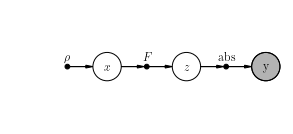

In [3]:
from tramp.models import glm_generative
from tramp.experiments import BayesOptimalScenario

teacher = glm_generative(
    N=1000, alpha=1.2, ensemble_type="gaussian", prior_type="gauss_bernouilli", 
    output_type="abs", prior_rho=0.5, prior_mean=0.1
)
for factor in teacher.factors:
    print(factor)
    scenario = BayesOptimalScenario(teacher, x_ids=["x", "z"])
scenario.setup()
scenario.student.plot()

## EP time evolution

In [4]:
ep_evo = scenario.ep_convergence(
    metrics=["mse", "sign_mse"], damping=0.1, max_iter=20
)

INFO:tramp.algos.message_passing:init message dag with ConstantInit(a=0,b=0)
INFO:tramp.algos.message_passing:f_0->x damping=0.1
INFO:tramp.algos.message_passing:f_1->z damping=0.1
INFO:tramp.algos.message_passing:x<-f_1 damping=0.1
INFO:tramp.algos.message_passing:z<-f_2 damping=0.1
INFO:tramp.algos.message_passing:terminated after n_iter=20 iterations


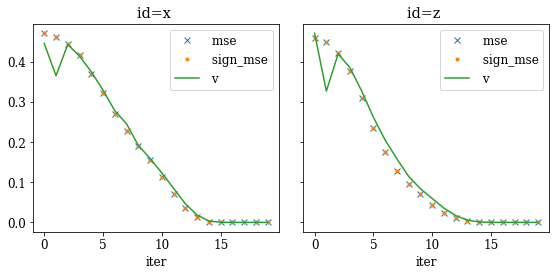

In [5]:
qplot(
    ep_evo, x="iter", y=["mse", "sign_mse", "v"],  
    y_markers=["x",".","-"], column="id", y_legend=True
)

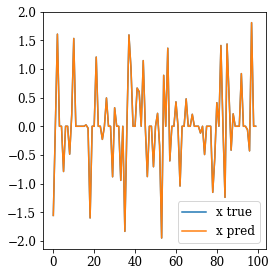

In [6]:
plot_compare(scenario.x_true["x"], scenario.x_pred["x"])

## MSE curve

See `data/sgn_retrieval_mse_curves.py` for the code

In [7]:
rename = {
    "alpha": r"$\alpha$", "prior_rho":r"$\rho$", "prior_mean":r"$\mu$",
    "a0=0.1": "uninformed", "a0=1000.0": "informed", 
    "v": "MSE", "n_iter":"iterations", "x_id=":"", 
    "criterion=": ""
}
mse_curves = pd.read_csv("data/sgn_retrieval_mse_curves.csv")

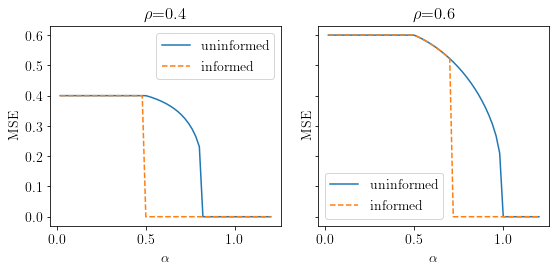

In [8]:
qplot(
    mse_curves.query("x_id=='x'"), 
    x="alpha", y="v", linestyle="a0", column="prior_rho",
    rename=rename, usetex=True, font_size=14
)

## Critical lines

See `data/sgn_retrieval_critical_lines.py` for the code

In [9]:
crit = pd.read_csv("data/sgn_retrieval_critical_lines.csv")

The critical lines are okay for the "informed" case ($a_0 = 1000$) and  "uninformed" case ($a_0=0.1$). A bit off for $\rho \sim 0$ or 1. Maybe $a_0=0.1$ too big for these $\rho$ values.

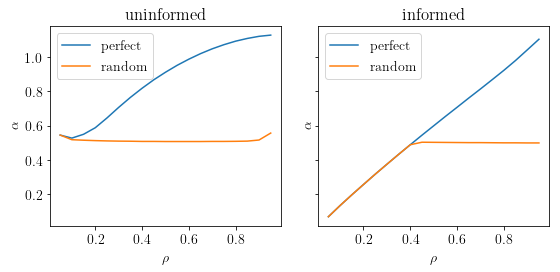

In [10]:
qplot(
    crit.query("a0>0 & prior_mean==0"), 
    x="prior_rho", y="alpha", column="a0", color="criterion",
    rename=rename, usetex=True, font_size=14
)

## Comments

Actually getting the correct phase diagram can be a little tricky.
For the truly uninformed case ($a_0 = 0$) at $\mu=0$ the state evolution cannot work.

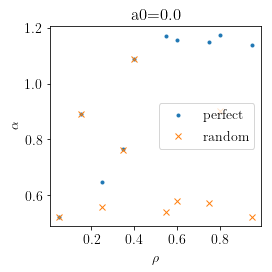

In [11]:
qplot(
    crit.query("a0==0 & prior_mean==0"), 
    x="prior_rho", y="alpha", column="a0", marker="criterion",
    rename=rename, usetex=True, font_size=14
)

To remedy this, we can:
1. use a slightly informed ($a_0 = 0.1$) as done above, we seem to recover the uninformed critical lines.
2. use a shift in the abs likelihood to break the symmetry. This isn't done in this notebook, but you can try for yourself with the `AsymmetricAbsLikelihood(shift=0.01)` or equivalently `ouput_type="a-abs"` and `ouput_shift=0.01`.
3. use a small prior mean $\mu=0.01$ to break the symmetry. Even for $a_0=0$ it converges. Unfortunatly, the critical line for the "no better than random guess" is a bit off.

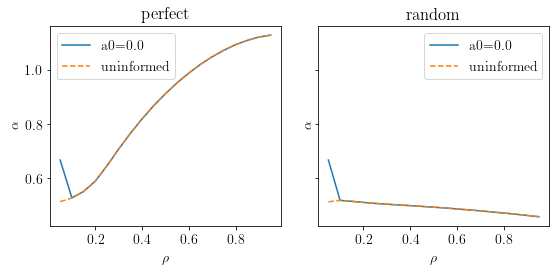

In [12]:
# for mu = 0.01, a0=0 works and gives the same result as a0=0.01
qplot(
    crit.query("prior_mean==0.01 & a0<1"), 
    x="prior_rho", y="alpha", linestyle="a0", column="criterion",
    rename=rename, usetex=True, font_size=14
)

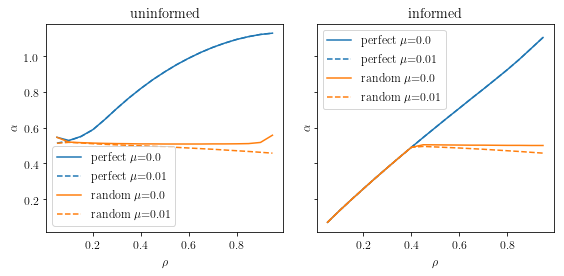

In [13]:
# mu=0.01 gives the same result as mu = 0 for the perfect phase
# but is off for the random phase
qplot(
    crit.query("a0>0"), 
    x="prior_rho", y="alpha", color="criterion", linestyle="prior_mean", column="a0", 
    rename=rename, usetex=True, font_size=12
)